In [2]:
from sectional_v2.util.eusaar_data import *
from sectional_v2.constants import get_plotpath
from sectional_v2.util.practical_functions import make_folders
from sectional_v2.constants import collocate_locations
from sectional_v2.util.plot.colors import get_case_col
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

/home/ubuntu/mnts/nird/projects//Output_data_OAS-DEV/


# load and autoreload

In [3]:
from IPython import get_ipython

# noinspection PyBroadException
try:
    _ipython = get_ipython()
    _magic = _ipython.magic
    _magic('load_ext autoreload')
    _magic('autoreload 2')
except:
    pass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from sectional_v2.constants import get_outdata_path

version = '_noresmv21'
path_in = get_outdata_path('eusaar')
file_in = path_in + 'Nd_cat_sources_timeseries%s.csv' % version
plot_path = get_plotpath('eusaar')
version = '_noresmv21_both'

## Read csv:

In [5]:
df = pd.read_csv(file_in, index_col=0, parse_dates=True)

## Add month to dataframe:

In [6]:
df['time'] = pd.to_datetime(df['time'])

df['season'] = df.to_xarray()['time.season'].to_series()

# df = pd.read_csv(file_in, index_col=0, parse_dates=True)

df_median = df.groupby(by=['source', 'station', 'season']).median()

## Add flags

In [7]:
df_median = df_median.drop(['flag_gd'], axis=1)

## Get percentiles and mask:

In [ ]:
def get_med_percs(df_masked,
                  lis=None,
                  q_low=0.16, q_high=0.84, by=None):
    if by is None:
        by = ['source', 'station', 'month']
    if lis is None:
        lis = ['station', 'N30-50', 'N50', 'N100', 'N250', 'N50-100',
               'N30-100', 'source', 'month']
    df_median_month = df_masked.groupby(by=by).median()

    df_perc16_month = df_masked[lis].groupby(by=by).quantile(q=q_low)
    df_perc84_month = df_masked[lis].groupby(by=by).quantile(q=q_high)
    return df_median_month, df_perc16_month, df_perc84_month

In [ ]:
df['month'] = df.to_xarray()['time.month'].to_series()

df_masked = df[df['flag_gd']]

df_median_month, df_perc16_month, df_perc84_month = get_med_percs(df_masked)

## Various functions

In [9]:
def make_new_cat():
    """
    Make new category
    """
    coll_ltr = collocate_locations.transpose()

    td = {
        'Low altitude sites (less than 1000 m a.s.l.)': 'LA',
        'High altitude sites (over 1000 m a.s.l.)': 'HA'
    }
    coll_ltr['AC'] = coll_ltr['Altitude category'].apply(lambda x: td[x])

    coll_ltr['new_cat'] = coll_ltr['AC'] + ': ' + coll_ltr['Region']
    coll_ltr = coll_ltr.sort_values('new_cat', ascending=False)
    return coll_ltr

def get_ordered_stations():
    coll_ltr = make_new_cat()
    return coll_ltr.index
list(get_ordered_stations())

['CBW',
 'MHD',
 'HWL',
 'VHL',
 'BIR',
 'ASP',
 'SMR',
 'PAL',
 'PLA',
 'FKL',
 'JRC',
 'KPO',
 'BOS',
 'WAL',
 'HPB',
 'OBK',
 'MPZ',
 'ZEP',
 'PDD',
 'CMN',
 'SSL',
 'ZSF',
 'JFJ',
 'BEO']

In [10]:
def plot_month_med_save(df_median_month, df_perc16_month, df_perc84_month, station_ls=None,
                        var='N50-100', figname_ext='all_stations',
                        ncols=4, nrows=6, figsize=None, ylim=None):
    _df = df_median_month.reset_index()  # .sort_values()'
    _df_16 = df_perc16_month.reset_index()  # .sort_values()'
    _df_84 = df_perc84_month.reset_index()  # .sort_values()'

    sns.set_style("whitegrid")
    # var = 'N50-100'
    if figsize is None:
        figsize = [10 / 4 * ncols, 10 / 6 * nrows]
    fig, figname_ext, labels, lines = plot_med_stations_month(_df, _df_16, _df_84, var, station_ls, figname_ext,
                                                              figsize, ncols, nrows, ylim)
    fig.tight_layout()
    print(labels)
    lgn = fig.legend(lines, labels, bbox_to_anchor=(0, 1., 1, 0.5),  # (0, -0.04, 1., .1),
                     loc='lower center', ncol=4,
                     # mode="expand",
                     borderaxespad=0., fontsize=11, frameon=False)  # bbox_to_anchor=(0, 1., 1, 0.5))

    fn = plot_path + '/Nd/' + var + 'monthly_variation%s_%s.' % (version, figname_ext)

    fig.savefig(fn + 'png', bbox_extra_artists=(lgn,), bbox_inches='tight')
    fig.savefig(fn + 'pdf', bbox_extra_artists=(lgn,), bbox_inches='tight')
    plt.show()

In [11]:
def plot_month_med_save_cat(df_median_month, df_perc16_month, df_perc84_month, station_ls=None,
                            var='N50-100', cat='all_stations',
                            ncols=4, nrows=6, figsize=None, ylim=None):
    _df = df_median_month.reset_index()  # .sort_values()'
    _df_16 = df_perc16_month.reset_index()  # .sort_values()'
    _df_84 = df_perc84_month.reset_index()  # .sort_values()'

    sns.set_style("whitegrid")
    # var = 'N50-100'
    if figsize is None:
        figsize = [10 / 4 * ncols, 10 / 6 * nrows]
    fig, cat, labels, lines = plot_med_stations_month(_df, _df_16, _df_84, var, station_ls, cat,
                                                      figsize, ncols, nrows, ylim)
    fig.tight_layout()
    lgn = fig.legend(lines, labels, bbox_to_anchor=(0, -0.01, 1, 0.5),  # (0, -0.04, 1., .1),
                     loc='lower center', ncol=4,
                     # mode="expand",
                     borderaxespad=0., fontsize=11, frameon=False)  # bbox_to_anchor=(0, 1., 1, 0.5))

    # fig.tight_layout(ad)#rect=(0,-0.5,1,1.5))
    # fig.tight_layout()
    su = plt.suptitle(cat, va='bottom')  # , y=-.05)
    # fig.subplots_adjust(top=.9)
    fn = plot_path + '/Nd/' + var + 'monthly_variation%s_%s.' % (version, cat)

    fig.savefig(fn + 'png', bbox_extra_artists=(lgn, su,), bbox_inches='tight')
    fig.savefig(fn + 'pdf', bbox_extra_artists=(lgn,), bbox_inches='tight')
    plt.show()

In [12]:
def plot_med_stations_month(_df, _df_16, _df_84, var, station_ls, figname_ext, figsize, ncols, nrows, ylim):
    fig, axs = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=figsize)
    if nrows == 1 and ncols == 1:
        axf = [axs]
    else:
        axf = axs.flatten()
    if station_ls is None:
        station_ls = list(get_ordered_stations())
        figname_ext = 'all_stations'
    for st, ax in zip(station_ls, axf):
        labels, lines = plt_station(_df, _df_16, _df_84, ax, st, var, ylim)
        if st =='ZEP':
            axins = ax.inset_axes([0.23, 0.2, 0.67, 0.67])#zoomed_inset_axes(ax, zoom=1, loc='upper right')
            labels, lines = plt_station(_df, _df_16, _df_84, axins, st, var, [0,300])
            axins.set_xticklabels('')
            axins.grid(False)
            axins.yaxis.label.set_color('red')
            axins.tick_params(axis='y', colors='red')
            #axins.tick_params(axis=u'both', which=u'both',length=1)
            ax.indicate_inset_zoom(axins,edgecolor='r',)
            axins.spines['left'].set_color('r')
            axins.spines['right'].set_color('r')
            axins.spines['bottom'].set_color('r')
            axins.spines['top'].set_color('r')
            axins.set_title('')
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

    if nrows == 1:
        axl = axs
    else:
        axl = axs[-1, :]
    if nrows == 1 and ncols == 1: axl = [axs]
    for ax in axl:
        ax.set_xlabel('Month')
    if nrows == 1 and ncols == 1:
        axl = [axs]
    elif nrows == 1:
        axl = [axs[0]]
    elif ncols == 1:
        axl = axs
    else:
        axl = axs[:, 0]
    for ax in axl:
        ax.set_ylabel('%s [#/cm$^3$]' % var)
    return fig, figname_ext, labels, lines

In [13]:
def plt_station(_df, _df_16, _df_84, ax, st, var, ylim):
    ax.set_xticks(range(1, 12, 2))
    _df_s = _df[_df['station'] == st]
    _df_s16 = _df_16[_df_16['station'] == st]
    _df_s84 = _df_84[_df_84['station'] == st]
    x = _df_s['month']
    y = _df_s
    lines = []
    labels = []
    for source in _df_s['source'].unique():
        _df_ss = _df_s[_df_s['source'] == source].set_index('month').reindex(
            range(1, 13))  # .set_index('month').reindex(range(1,13))
        # print(_df_ss[var])
        line = ax.plot(_df_ss.index, _df_ss[var], color=get_case_col(source), label=source, marker='*', markersize=4)
        lines = lines + line  # s[0]
        labels.append(source)
        _df_ss16 = _df_s16[_df_s16['source'] == source].set_index('month').reindex(range(1, 13))
        _df_ss84 = _df_s84[_df_s84['source'] == source].set_index('month').reindex(range(1, 13))
        ax.fill_between(_df_ss16.index, _df_ss16[var], _df_ss84[var], color=get_case_col(source), alpha=0.3)
    ax.set_title(st)
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.set_xlim([.8,12.2])
    return labels, lines

['SECTv21_ctrl', 'eusaar', 'noSECTv21_default', 'noSECTv21_ox_ricc']


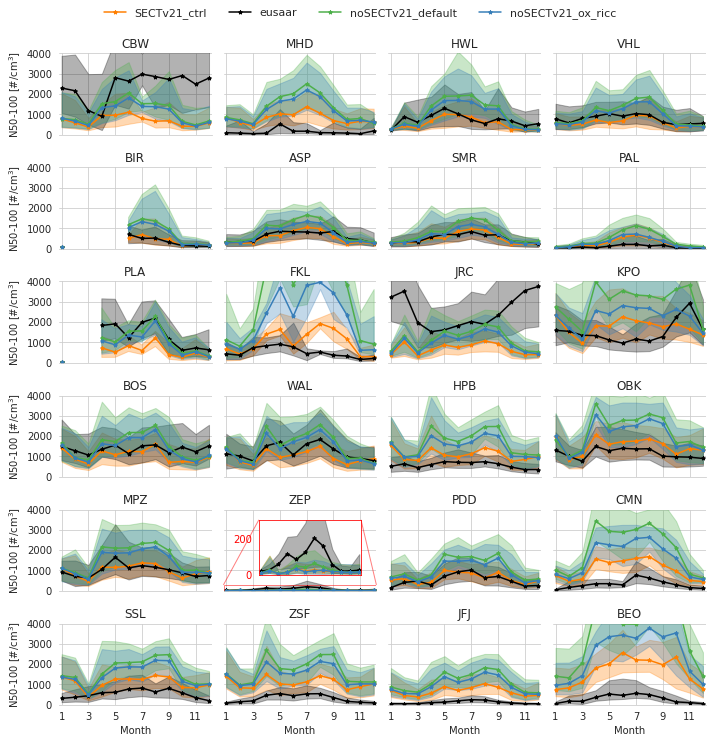

In [14]:
plot_month_med_save(df_median_month, df_perc16_month, df_perc84_month, var='N50-100', ylim=[0, 4000])

In [15]:
coll_ltr= make_new_cat()

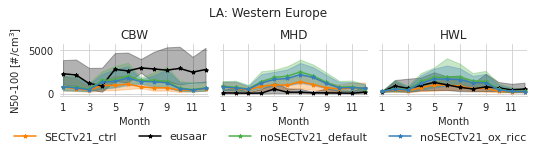

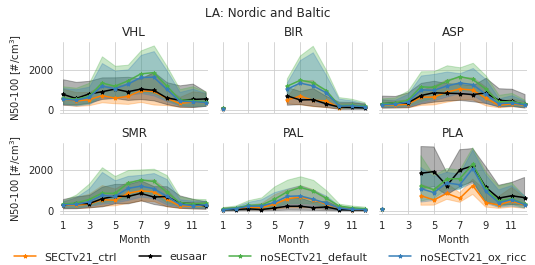

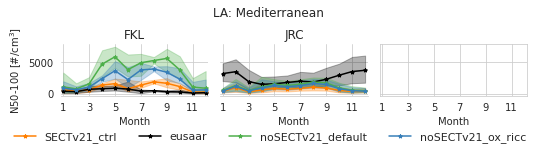

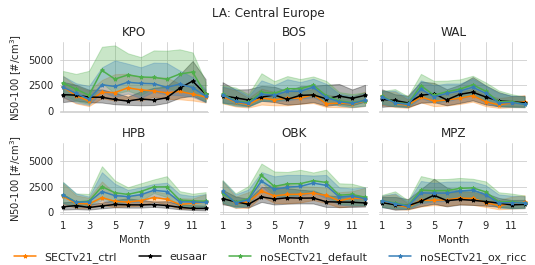

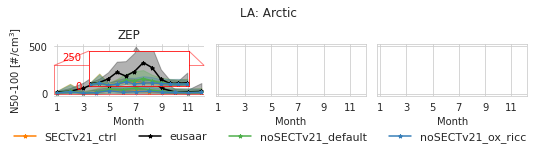

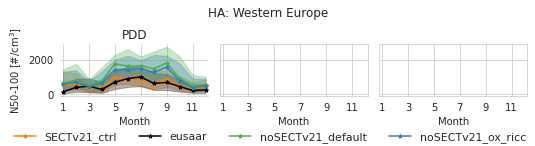

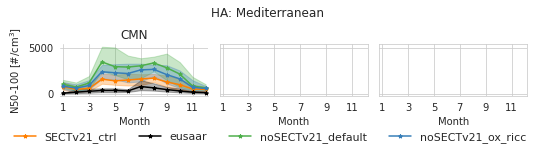

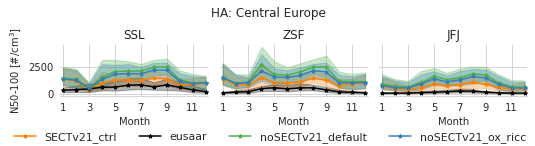

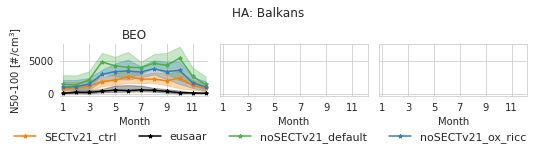

In [16]:
cats = coll_ltr['new_cat'].unique()
for cat in cats:
    st_ls = (coll_ltr[coll_ltr['new_cat'] == cat].index)
    nrows = int(np.ceil(len(st_ls) / 3))
    plot_month_med_save_cat(df_median_month, df_perc16_month, df_perc84_month, station_ls=st_ls,
                            cat=cat, ncols=3, nrows=nrows)